## Evaluation by canal

In [16]:
from bones_dataloader import *

dataset_dir = "../../datasets/BONE_CHANNELS"

batch_size = 6
patch_size = (640, 640)
color_model = "RGB"

augmentation_strategy = "random" # "no_augmentation", "color_augmentation", "inpainting_augmentation", "standard", "random"
augmentation = [None,
                "horizontal_flip", 
                "vertical_flip", 
                "rotation", 
                "transpose", 
                "elastic_transformation", 
                "grid_distortion", 
                "optical_distortion",
                #"color_transfer", 
                #"inpainting"]
]

dataloaders = create_dataloader(tile_size="{}x{}".format(patch_size[0], patch_size[1]),
                                batch_size=batch_size, 
                                shuffle=True,
                                img_input_size=patch_size,
                                img_output_size=patch_size,
                                dataset_dir=dataset_dir,
                                color_model=color_model,
                                augmentation=augmentation,
                                augmentation_strategy=augmentation_strategy,
                                start_epoch=1,
                                validation_split=0.2)

dataset_train_size = len(dataloaders['train'].dataset)
dataset_test_size = len(dataloaders['test'].dataset)
set_size = len(dataloaders['test'].dataset.samples)
logger.info(dataset_test_size)
logger.info(dataset_train_size)

2023-11-12 10:50:21,737 :: INFO load_dataset :: [training] ../../datasets/BONE_CHANNELS/training
2023-11-12 10:50:21,811 :: INFO load_dataset :: [training] ../../datasets/BONE_CHANNELS/training
2023-11-12 10:50:21,881 :: INFO load_dataset :: [testing] ../../datasets/BONE_CHANNELS/testing
2023-11-12 10:50:21,903 :: INFO create_dataloader :: Train images (640x640): 1258 augmentation: random
2023-11-12 10:50:21,903 :: INFO create_dataloader :: Valid images (640x640): 315 augmentation: no_augmentation
2023-11-12 10:50:21,904 :: INFO create_dataloader :: Test images (640x640): 464 augmentation: no_augmentation
2023-11-12 10:50:21,905 :: INFO <module> :: 464
2023-11-12 10:50:21,905 :: INFO <module> :: 1258


In [ ]:
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage.measure import regionprops
from PIL import Image 
import numpy as np
import csv

percentage_inclusion_threshold = 0.7

# Arquivo com as métricas médias para cada p
csv_mean_file_path = '../../datasets/BONE_CHANNELS/results/BONE_CHANNELS__Size-640x640_Epoch-100_Images-464_Batch-1__random_distortion/testing/canals/mean_quantitative_analysis.csv'
mean_file = open(csv_mean_file_path, newline='', mode='w')
mean_writer = csv.writer(mean_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
mean_writer.writerow(['prob_threshold', 'accuracy', 'precision', 'f1/dice', 'sensitivity/recall', 'tp', 'tn', 'fp'])



for threshold_prob in np.arange(0.0,1.0,0.05):
    csv_file_path = f'../../datasets/BONE_CHANNELS/results/BONE_CHANNELS__Size-640x640_Epoch-100_Images-464_Batch-1__random_distortion/testing/canals/quantitative_analysis_{"%.3f" % threshold_prob}.csv'

    sum_accuracy = 0
    sum_precision = 0
    sum_f1 = 0
    sum_recall = 0
    sum_vp = 0
    sum_vn = 0
    sum_fp = 0

    with open(csv_file_path, newline='', mode='w') as medidas_file:
        medidas_writer = csv.writer(medidas_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        medidas_writer.writerow(['wsi_image', 'accuracy', 'precision', 'f1/dice', 'sensitivity/recall', 'tp', 'tn', 'fp'])


        for image in range(set_size):
        
            # Verdadeiros positivos (São canais e foram segmentados como canais)
            vp = 0
            # Verdadeiros negativos (São canais mas não foram segmentados como canais)
            vn = 0
            # Falsos positivos (Não são canais mas foram segmentados como canais)
            fp = 0
    
            original_mask   = Image.open(dataloaders['test'].dataset.samples[image][1])
            fname = dataloaders['test'].dataset.samples[image][1].split('\\')[1]
            segmented_mask  = Image.open(f'../../datasets/BONE_CHANNELS/results/BONE_CHANNELS__Size-640x640_Epoch-100_Images-464_Batch-1__random_distortion/testing/bones/patch/640x640/binary_images/prob_{"%.3f" % threshold_prob}/{fname}')
    
            original_mask_np = np.array(original_mask)
            segmented_mask_np = np.array(segmented_mask)[:, :, 0]
    
            already_processed_components = []
            labeled_original_mask, nr_original_objects = ndimage.label(original_mask_np != 0.)
            original_mask_props = regionprops(labeled_original_mask)
    
            labeled_segmented_mask, nr_segmented_objects = ndimage.label(segmented_mask_np != 0.)
    
            for prop_idx in range(len(original_mask_props)):
                ## Calcula verdadeiros positivos e negativos
                [X, Y, x, y] = original_mask_props[prop_idx].bbox  
    
                bitwised = np.bitwise_and(original_mask_np[X:x, Y:y], segmented_mask_np[X:x, Y:y])
                #plt.imshow(original_mask_np[X:x, Y:y])
                #plt.show()
                #plt.imshow(segmented_mask_np[X:x, Y:y])
                #plt.show()  
                #plt.imshow(bitwised)
                #plt.show()  
    
                count_original = np.count_nonzero(original_mask_np[X:x, Y:y])
                count_intersection = np.count_nonzero(bitwised) 
                percent_included = abs(count_intersection/count_original) 
    
                if percent_included >= percentage_inclusion_threshold:
                    vp = vp + 1
    
                    ## Armazena relações de labels
                    bbox_labeled = labeled_original_mask[X:x, Y:y]
                    a = np.nonzero(bbox_labeled)[0][0]
                    b = np.nonzero(bbox_labeled)[1][0]
                    original_mask_label = bbox_labeled[a][b]
    
                    bbox_labeled = labeled_segmented_mask[X:x, Y:y]
                    a = np.nonzero(bbox_labeled)[0][0]
                    b = np.nonzero(bbox_labeled)[1][0]
                    segmented_mask_label = bbox_labeled[a][b]
                    already_processed_components.append((original_mask_label, segmented_mask_label))
                else:
                    vn = vn + 1
                    bbox_labeled = labeled_original_mask[X:x, Y:y]
                    a = np.nonzero(bbox_labeled)[0][0]
                    b = np.nonzero(bbox_labeled)[1][0]
                    original_mask_label = bbox_labeled[a][b]
                    already_processed_components.append((original_mask_label, None))
    
            segmented_mask_props = regionprops(labeled_segmented_mask)
    
            for prop_idx in range(len(segmented_mask_props)):
                ## Verifica se componente já foi processado
                [X, Y, x, y] = segmented_mask_props[prop_idx].bbox
                bbox_labeled = labeled_segmented_mask[X:x, Y:y]
                a = np.nonzero(bbox_labeled)[0][0]
                b = np.nonzero(bbox_labeled)[1][0]
                current_component_label = bbox_labeled[a][b]
                alread_processed = False
    
                for i in already_processed_components:
                    if i[1] == current_component_label:
                        alread_processed = True
                        break
                    
                if alread_processed:
                    break
                
                fp = fp + 1
                already_processed_components.append((None, current_component_label))
    
            #print('Verdadeiros positivos: ' + str(vp))
            #print('Verdadeiros negativos: ' + str(vn))
            #print('Falsos positivos: ' + str(fp))
    
            if vp == 0:
                precision = 0
                recall = 0
                f1 = 0
                accuracy = 0    
            else:
                precision = vp/(vp + fp)
                recall = vp/(vp + vn)
                f1 = (2*precision*recall)/(precision + recall)
                accuracy = vp/(vp + vn + fp)
    
            #print('Acurácia: ' + str(accuracy))
            #print('Sensibilidade: ' + str(recall))
            #print('Precisão: ' + str(precision))
            #print('F1-Score: ' + str(f1))
    
            # escreve linha no arquivo local
            medidas_writer.writerow([fname, accuracy, precision, f1, recall, vp, vn, fp])
        sum_accuracy = sum_accuracy + accuracy
        sum_precision = sum_precision + precision
        sum_f1 = sum_f1 + f1
        sum_recall = sum_recall + recall
        sum_vp = sum_vp + vp
        sum_vn = sum_vn + vn
        sum_fp = sum_fp + fp

    # escreve linha no arquivo de medias
    mean_writer.writerow([threshold_prob, sum_accuracy/set_size, sum_precision/set_size, sum_f1/set_size, sum_recall/set_size, sum_vp/set_size, sum_vn/set_size, sum_fp/set_size])
    



In [29]:
import numpy as np
import pandas as pd
import os

dir = f'../../datasets/BONE_CHANNELS/results/BONE_CHANNELS__Size-640x640_Epoch-100_Images-464_Batch-1__random_distortion/testing/canals/'
files = os.listdir(dir)

means_matrix = np.zeros((20, 7))
for idx in range(len(files)):
    print(files[idx])
    my_data = np.genfromtxt(dir + files[idx], delimiter=',')

    my_data = np.delete(my_data, 0, 0)
    my_data = np.delete(my_data, 0, 1)

    means_row = []
    for col in range(len(my_data[0,:])):
        means_row.append(np.sum(my_data[:,col])/(len(my_data[:,col])))

    means_matrix[idx,:] = np.array(means_row)
np.round(means_matrix, 3, means_matrix)
df = pd.DataFrame(means_matrix)
df['file'] = files
# Save DataFrame to .csv
df.to_csv(dir + 'means.csv', index=False, header=['accuracy', 'precision', 'f1/dice', 'sensitivity/recall', 'tp', 'tn', 'fp', 'file'])
#print(means_matrix)

quantitative_analysis_0.000.csv
quantitative_analysis_0.050.csv
quantitative_analysis_0.100.csv
quantitative_analysis_0.150.csv
quantitative_analysis_0.200.csv
quantitative_analysis_0.250.csv
quantitative_analysis_0.300.csv
quantitative_analysis_0.350.csv
quantitative_analysis_0.400.csv
quantitative_analysis_0.450.csv
quantitative_analysis_0.500.csv
quantitative_analysis_0.550.csv
quantitative_analysis_0.600.csv
quantitative_analysis_0.650.csv
quantitative_analysis_0.700.csv
quantitative_analysis_0.750.csv
quantitative_analysis_0.800.csv
quantitative_analysis_0.850.csv
quantitative_analysis_0.900.csv
quantitative_analysis_0.950.csv


C:\Users\Igor\AppData\Local\Temp\ipykernel_26080\468640626.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3)


Verdadeiros positivos: 3087
Verdadeiros negativos: 451
Falsos positivos: 649
Acurácia: 0.7372820635299737
Sensibilidade: 0.8725268513284341
Precisão: 0.8262847965738758
F1-Score: 0.8487764641187792


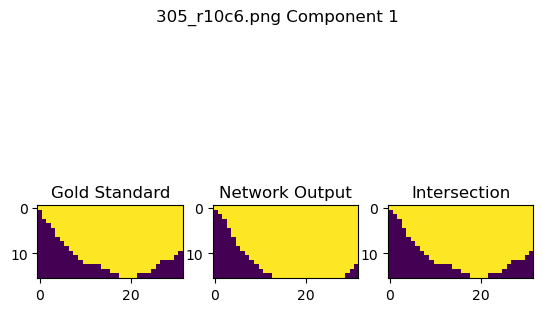

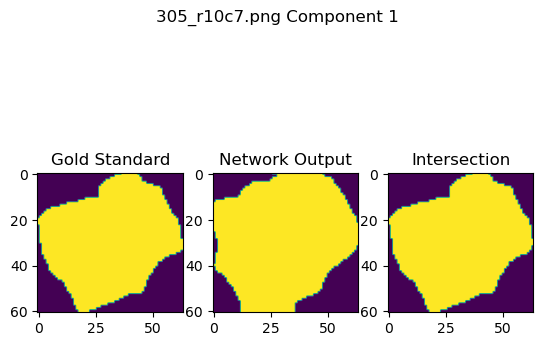

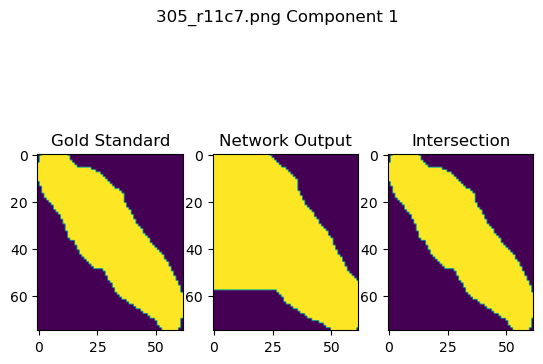

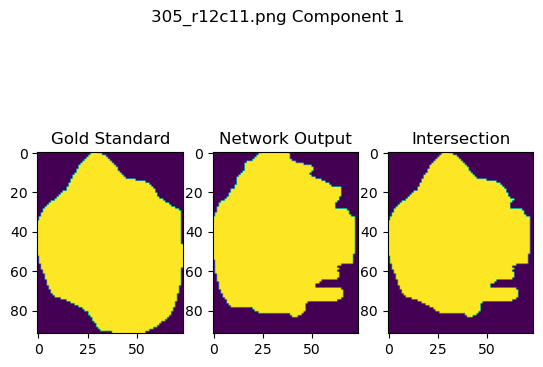

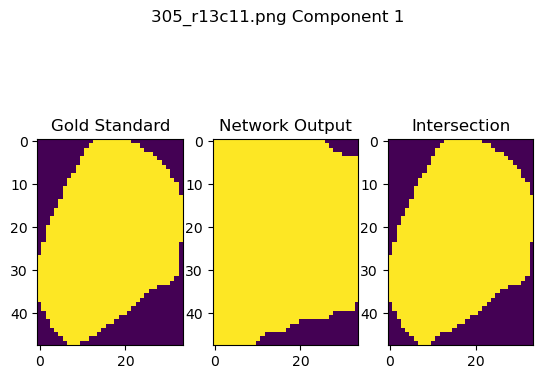

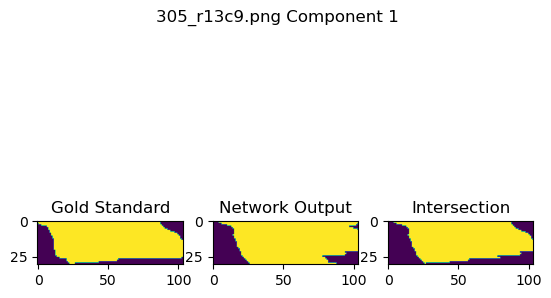

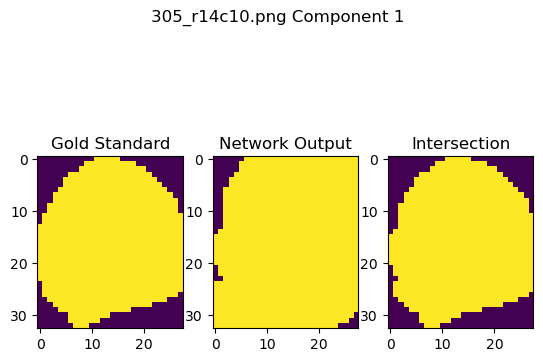

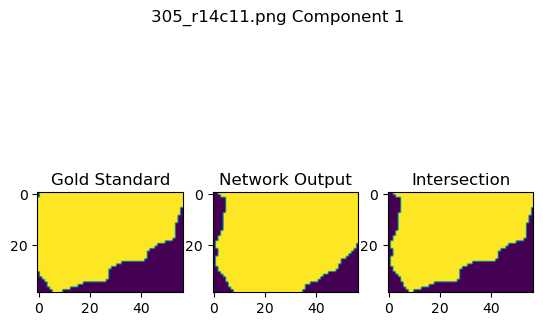

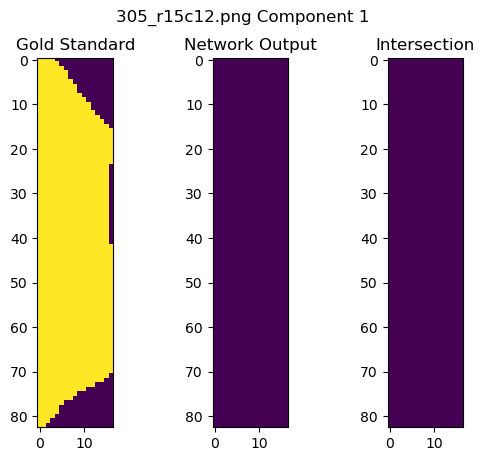

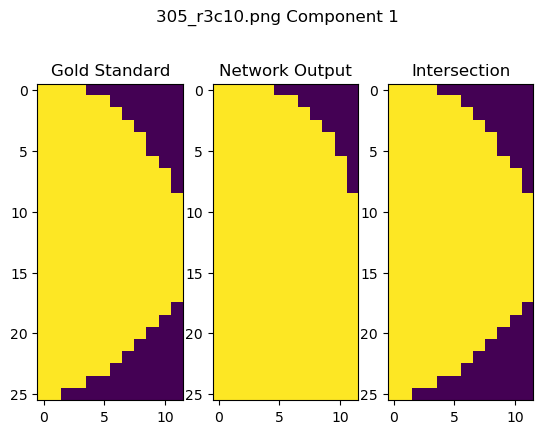

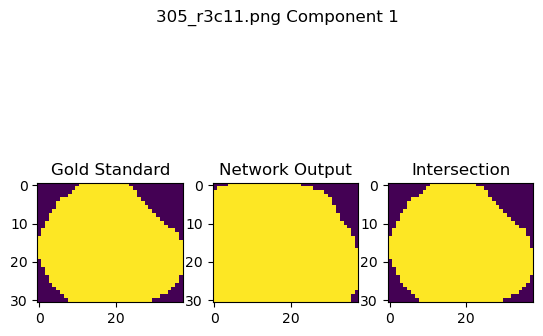

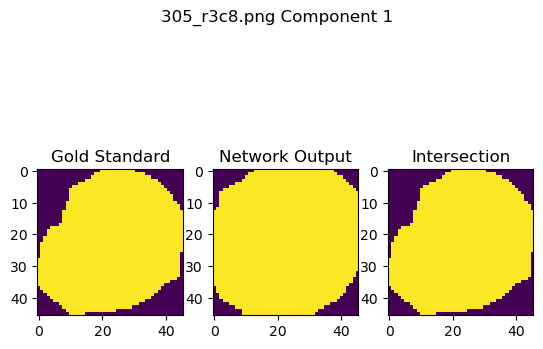

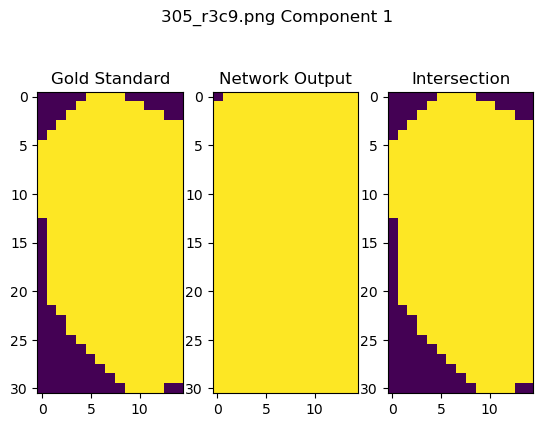

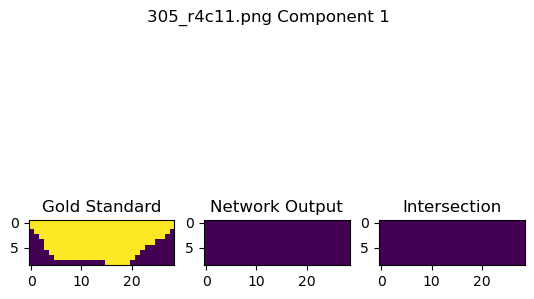

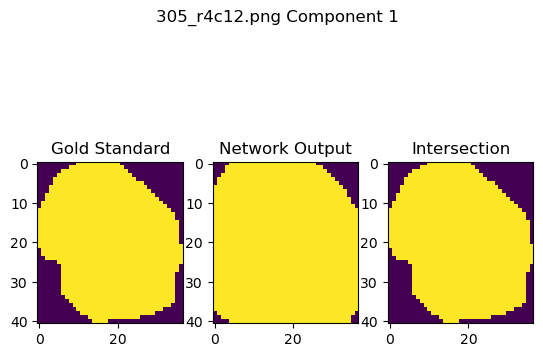

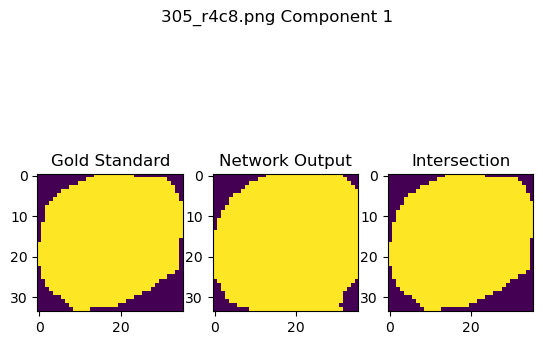

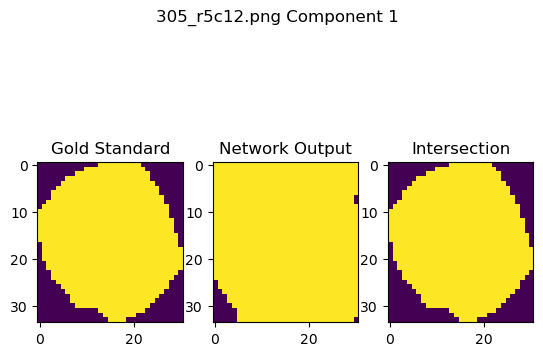

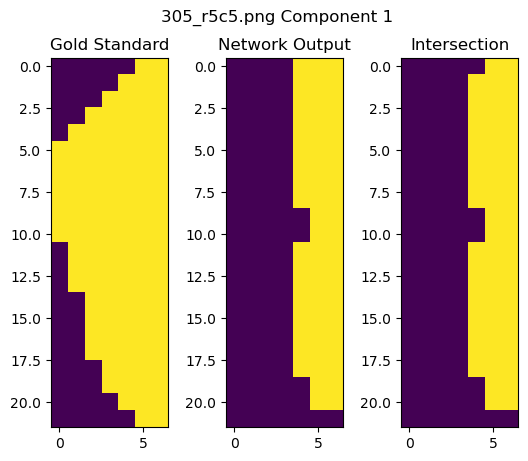

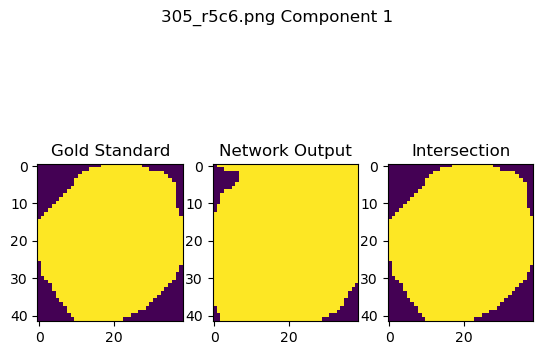

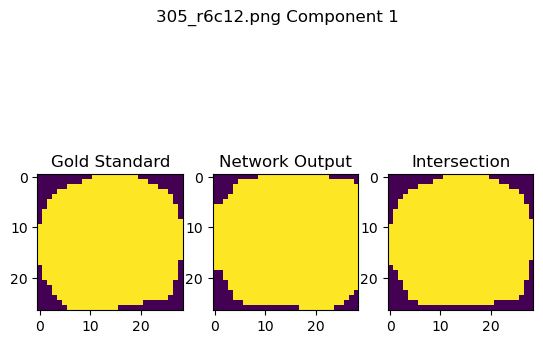

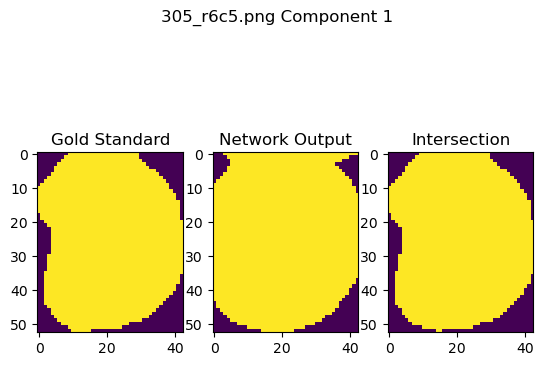

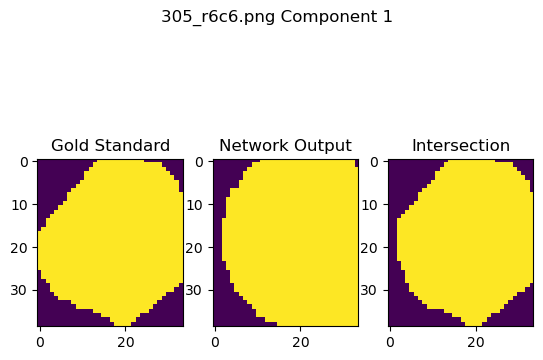

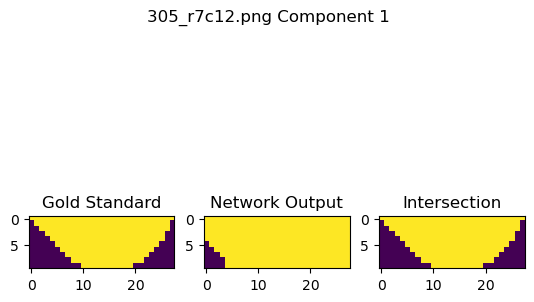

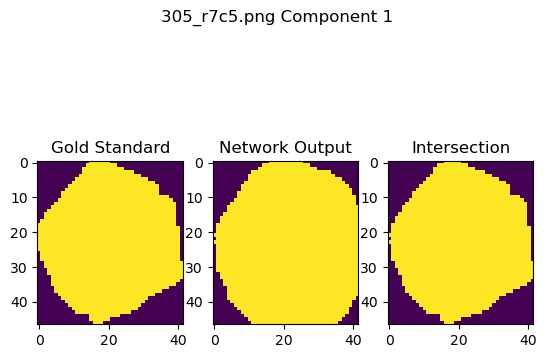

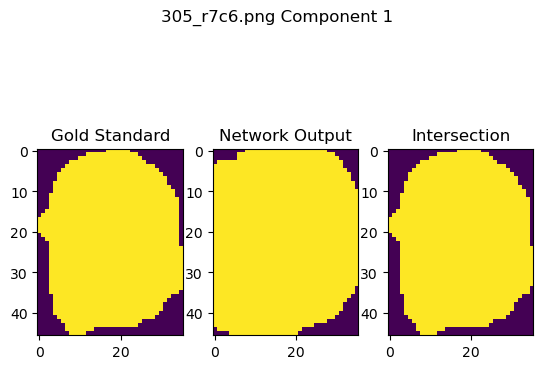

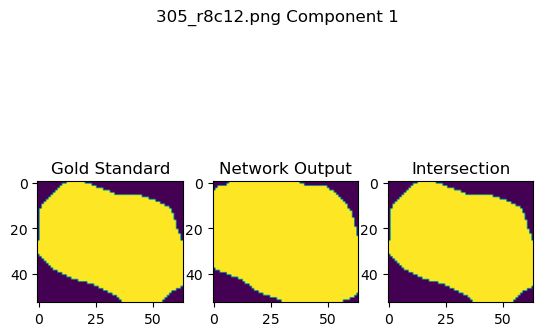

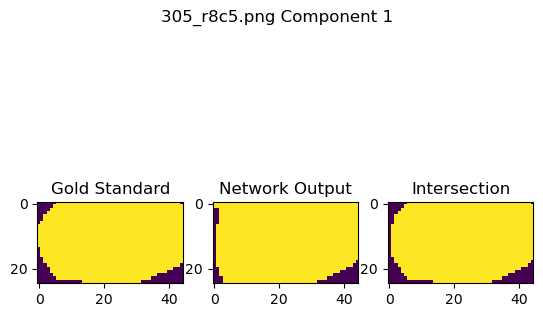

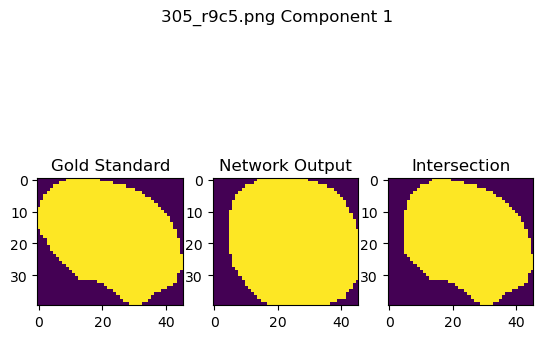

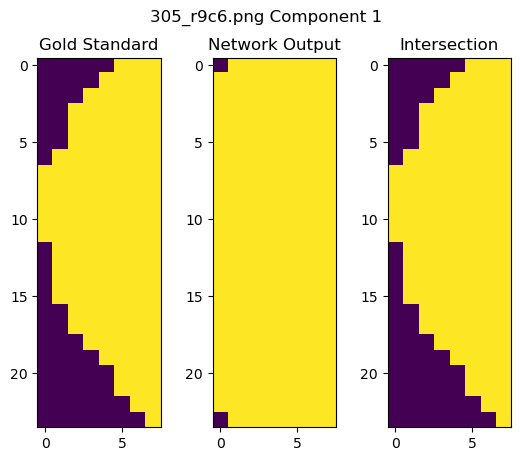

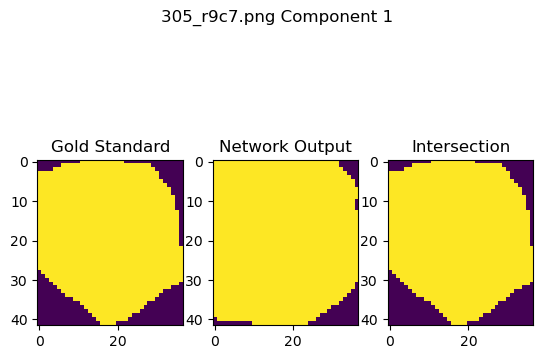

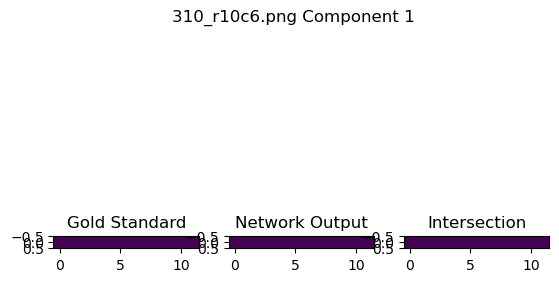

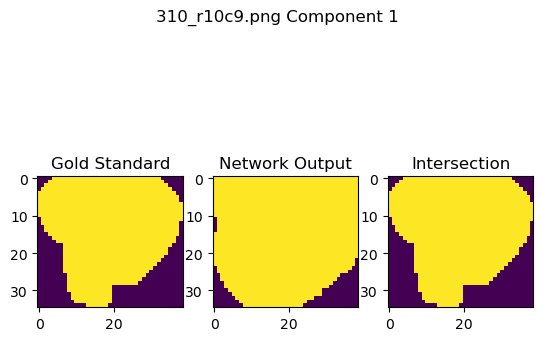

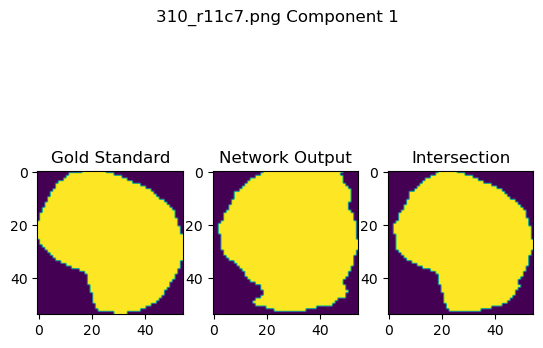

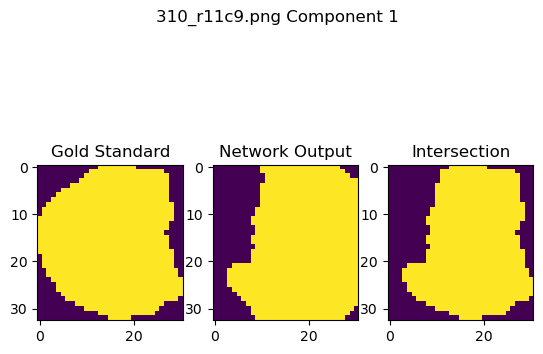

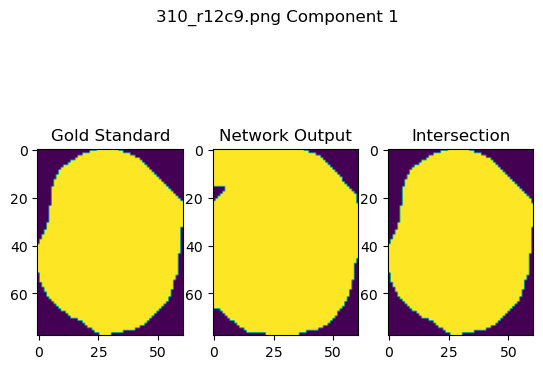

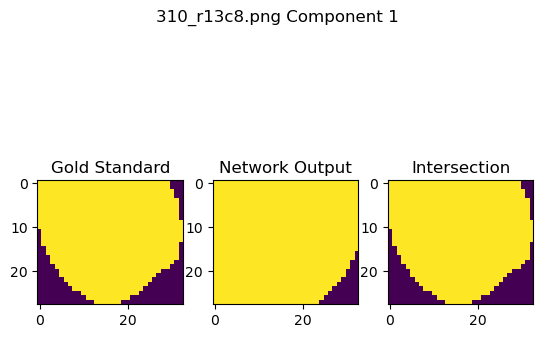

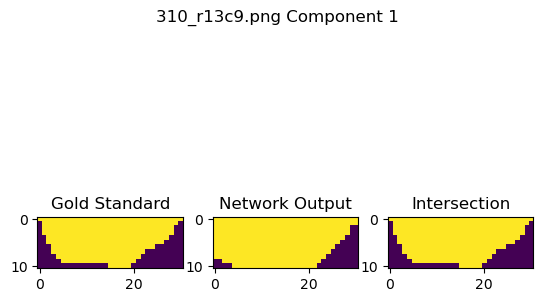

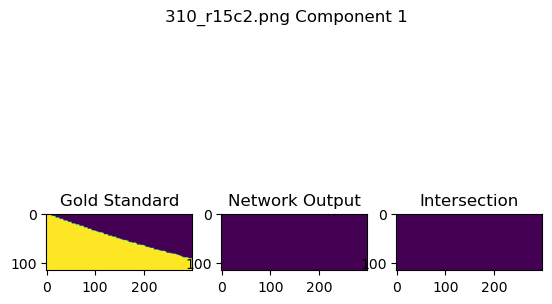

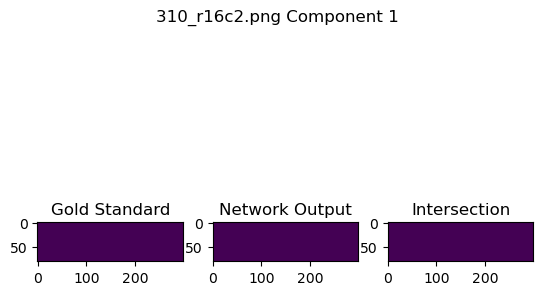

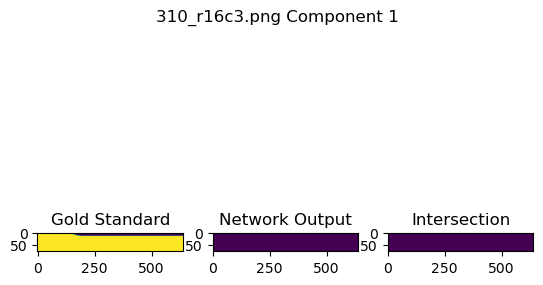

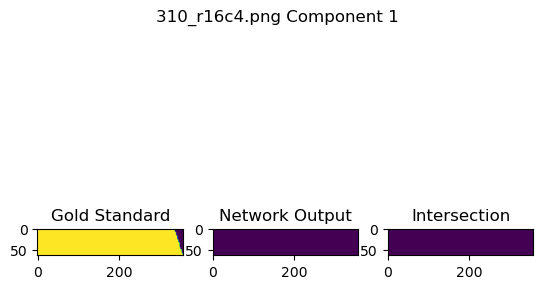

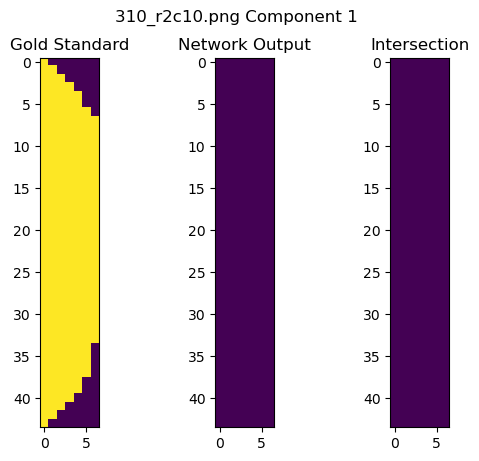

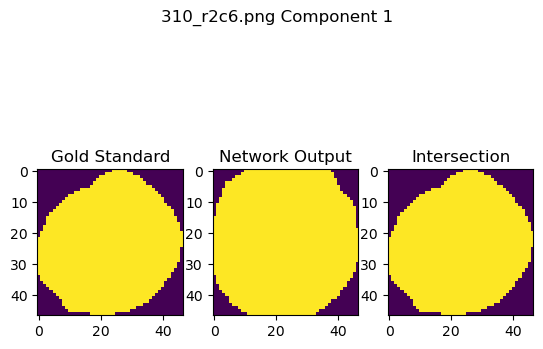

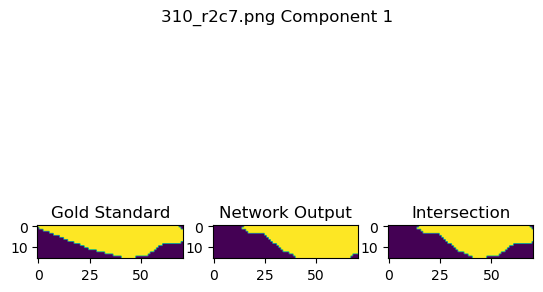

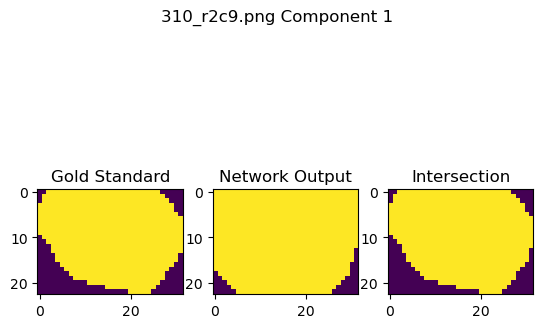

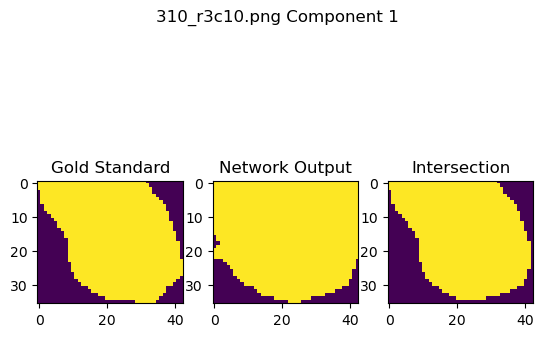

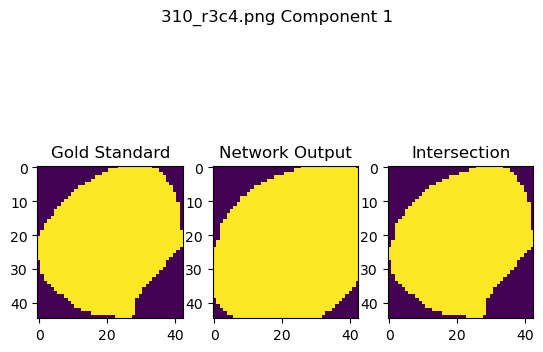

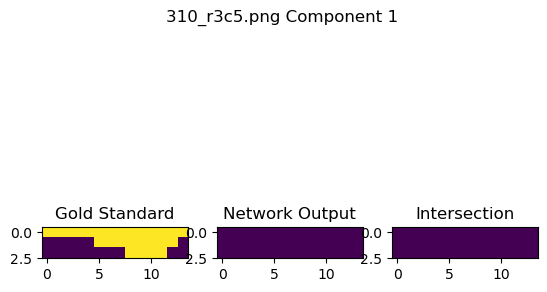

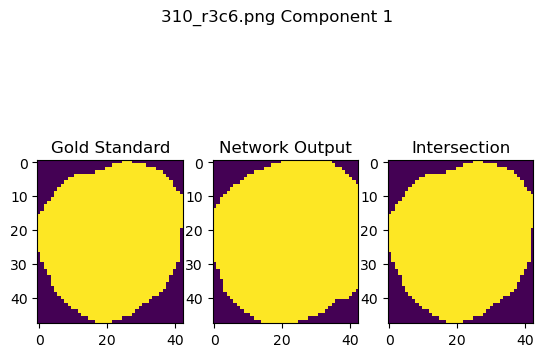

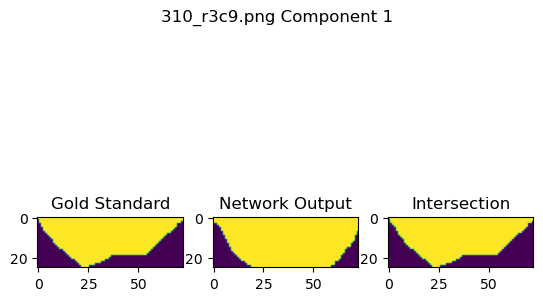

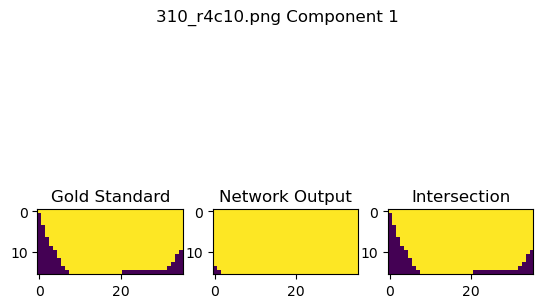

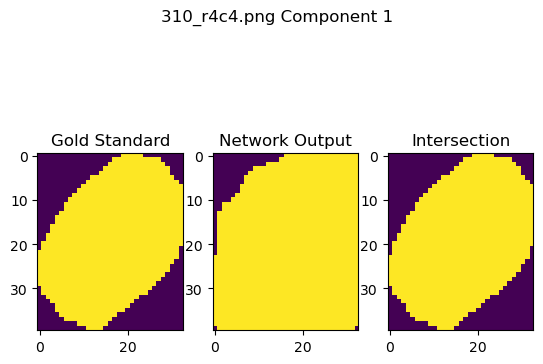

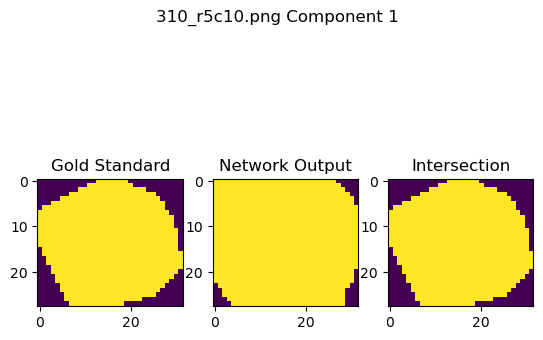

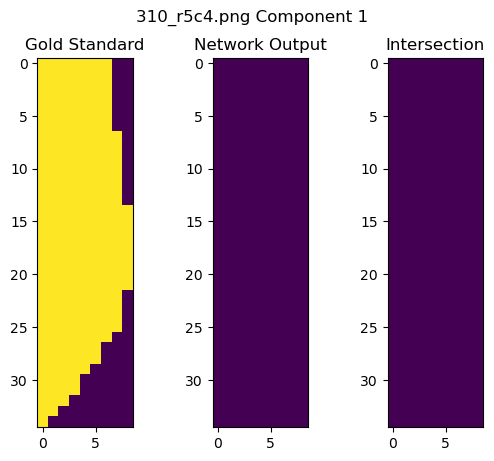

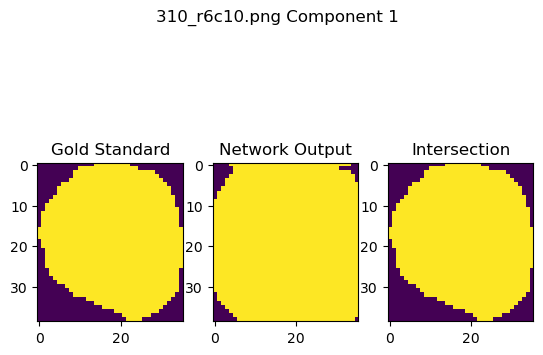

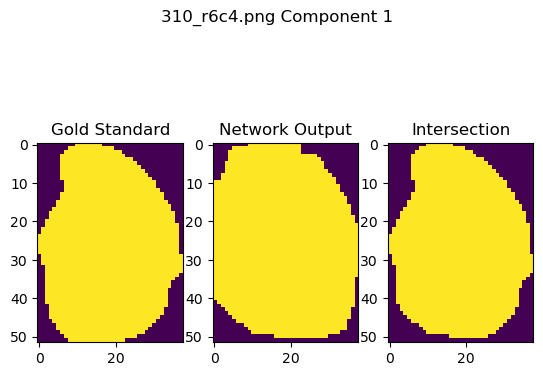

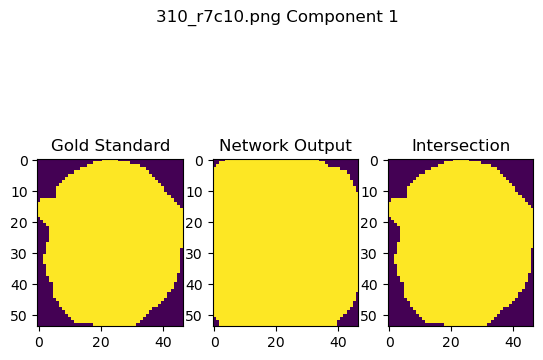

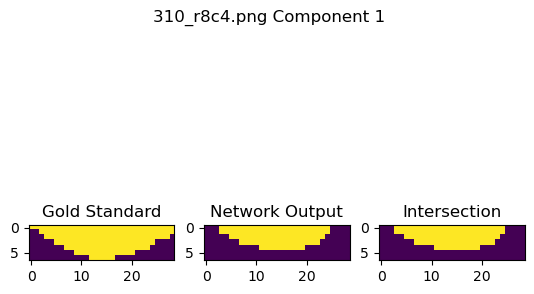

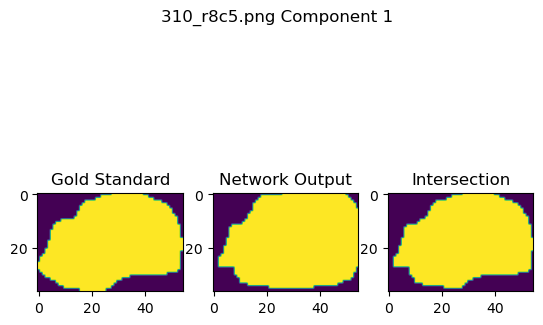

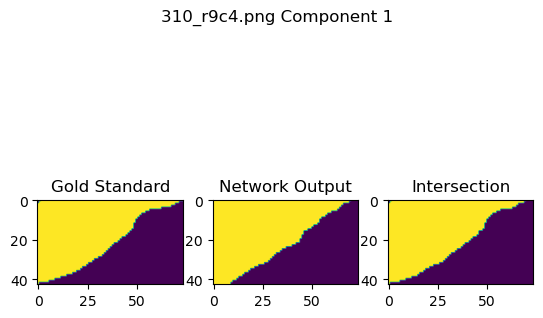

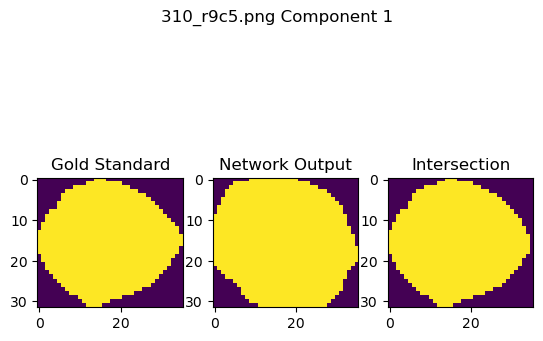

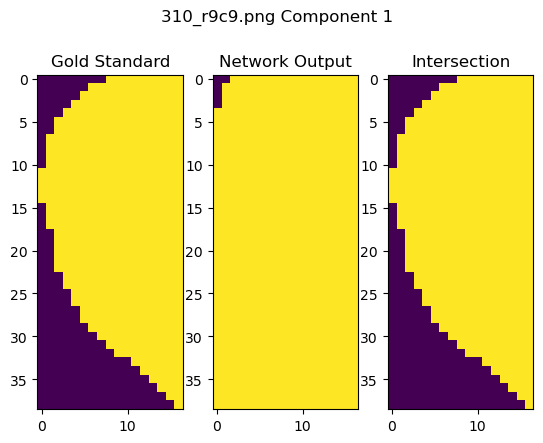

In [26]:
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage.measure import regionprops
from PIL import Image 
import numpy as np

probability_threshold_selected = 0.1
percentage_inclusion_threshold = 0.7
# Verdadeiros positivos (São canais e foram segmentados como canais)
vp = 0
# Verdadeiros negativos (São canais mas não foram segmentados como canais)
vn = 0
# Falsos positivos (Não são canais mas foram segmentados como canais)
fp = 0

for image in range(set_size):

    original_mask   = Image.open(dataloaders['test'].dataset.samples[image][1])
    fname = dataloaders['test'].dataset.samples[image][1].split('\\')[1]
    segmented_mask  = Image.open(f'../../datasets/BONE_CHANNELS/results/BONE_CHANNELS__Size-640x640_Epoch-100_Images-464_Batch-1__random_distortion/testing/bones/patch/640x640/binary_images/prob_{"%.3f" % probability_threshold_selected}/{fname}')
    original_mask_np = np.array(original_mask)
    segmented_mask_np = np.array(segmented_mask)[:, :, 0]
    already_processed_components = []
    labeled_original_mask, nr_original_objects = ndimage.label(original_mask_np != 0.)
    original_mask_props = regionprops(labeled_original_mask)
    labeled_segmented_mask, nr_segmented_objects = ndimage.label(segmented_mask_np != 0.)
    for prop_idx in range(len(original_mask_props)):
        ## Calcula verdadeiros positivos e negativos
        [X, Y, x, y] = original_mask_props[prop_idx].bbox  
        bitwised = np.bitwise_and(original_mask_np[X:x, Y:y], segmented_mask_np[X:x, Y:y])
        
        # Mostra alguns componentes
        if prop_idx == 0 and (int(fname.split('.')[0].split('_')[0]) % 5) == 0:
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
            fig.suptitle(f'{fname} Component {prop_idx+1}')
            ax1.set_title('Gold Standard')
            ax1.imshow(original_mask_np[X:x, Y:y])
            ax2.set_title('Network Output')
            ax2.imshow(segmented_mask_np[X:x, Y:y])
            ax3.set_title('Intersection')
            ax3.imshow(bitwised)

        count_original = np.count_nonzero(original_mask_np[X:x, Y:y])
        count_intersection = np.count_nonzero(bitwised) 
        percent_included = abs(count_intersection/count_original) 
        if percent_included >= percentage_inclusion_threshold:
            vp = vp + 1
            ## Armazena relações de labels
            bbox_labeled = labeled_original_mask[X:x, Y:y]
            a = np.nonzero(bbox_labeled)[0][0]
            b = np.nonzero(bbox_labeled)[1][0]
            original_mask_label = bbox_labeled[a][b]
            bbox_labeled = labeled_segmented_mask[X:x, Y:y]
            a = np.nonzero(bbox_labeled)[0][0]
            b = np.nonzero(bbox_labeled)[1][0]
            segmented_mask_label = bbox_labeled[a][b]
            already_processed_components.append((original_mask_label, segmented_mask_label))
        else:
            vn = vn + 1
            bbox_labeled = labeled_original_mask[X:x, Y:y]
            a = np.nonzero(bbox_labeled)[0][0]
            b = np.nonzero(bbox_labeled)[1][0]
            original_mask_label = bbox_labeled[a][b]
            already_processed_components.append((original_mask_label, None))
    segmented_mask_props = regionprops(labeled_segmented_mask)
    for prop_idx in range(len(segmented_mask_props)):
        ## Verifica se componente já foi processado
        [X, Y, x, y] = segmented_mask_props[prop_idx].bbox
        bbox_labeled = labeled_segmented_mask[X:x, Y:y]
        a = np.nonzero(bbox_labeled)[0][0]
        b = np.nonzero(bbox_labeled)[1][0]
        current_component_label = bbox_labeled[a][b]
        alread_processed = False
        for i in already_processed_components:
            if i[1] == current_component_label:
                alread_processed = True
                break
        if alread_processed:
            break
        fp = fp + 1
        already_processed_components.append((None, current_component_label))


print('Verdadeiros positivos: ' + str(vp))
print('Verdadeiros negativos: ' + str(vn))
print('Falsos positivos: ' + str(fp))
precision = vp/(vp + fp)
recall = vp/(vp + vn)
f1 = (2*precision*recall)/(precision + recall)
accuracy = vp/(vp + vn + fp)
print('Acurácia: ' + str(accuracy))
print('Sensibilidade: ' + str(recall))
print('Precisão: ' + str(precision))
print('F1-Score: ' + str(f1))
